In [31]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

In [32]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")

In [33]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols)

In [34]:
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+------------------+--------------------+-------------------+--------------------+--------------------+
|            author|                 sha|        commit_date|        failed_tests|               files|
+------------------+--------------------+-------------------+--------------------+--------------------+
|  naveensrinivasan|b3496f90ed1990a09...|2021/10/05 01:49:59|                  []|[{{16, 16, 0, .gi...|
|xinrong-databricks|033c2c83787006757...|2021/10/04 23:33:11|[pyspark.ml.tests...|[{{2, 4, 2, pytho...|
|xinrong-databricks|58ac86e39b59dd400...|2021/10/04 22:30:37|[pyspark.ml.tests...|[{{27, 48, 21, py...|
+------------------+--------------------+-------------------+--------------------+--------------------+
only showing top 3 rows



In [35]:
import json
from pathlib import Path 
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)

In [36]:
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())

to_train_features, _ = ptesting_model._create_train_test_pipeline(spark, test_files, commits, dep_graph, updated_file_stats, contributor_stats, failed_tests)
pdf = to_train_features.__call__(log_data_df).toPandas()

In [37]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=1.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-10-27 23:39:28.592 INFO train: Sampling training data (strategy={0: 861, 1: 861}): {0: 131034, 1: 861} => {0: 861, 1: 861}


In [38]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,file_card,failed_num_7d,failed_num_14d,failed_num_28d,failed_num_7c,failed_num_14c,failed_num_28c,total_failed_num,path_difference,distance
count,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.00000,1722.000000,1722.000000,1722.000000
mean,97.421603,3.365854,8.558653,15.927991,0.342044,0.522067,4.005226,1035.120790,208.678281,1243.799071,15.698026,0.527294,0.563879,0.627758,0.005807,0.011614,0.02381,1.261905,4.866434,55.393148
std,149.858085,3.983516,7.819082,13.148220,1.854300,2.003434,3.758620,8954.178584,926.869281,9170.886938,65.802607,0.557667,0.605741,0.697132,0.076005,0.117518,0.17049,1.532313,3.586021,62.453947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,48.000000,7.000000,55.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,2.000000
50%,83.000000,1.000000,6.000000,19.000000,0.000000,0.000000,3.000000,58.000000,8.000000,82.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,5.000000,2.000000
75%,83.000000,8.000000,18.000000,20.000000,0.000000,0.000000,8.000000,177.000000,48.000000,232.000000,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,6.000000,128.000000
max,887.000000,25.000000,27.000000,100.000000,20.000000,21.000000,25.000000,130829.000000,9386.000000,132030.000000,793.000000,3.000000,4.000000,7.000000,1.000000,2.000000,3.00000,12.000000,128.000000,128.000000


array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>],
       [<AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>,
        <AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>],
       [<AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>],
       [<AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_

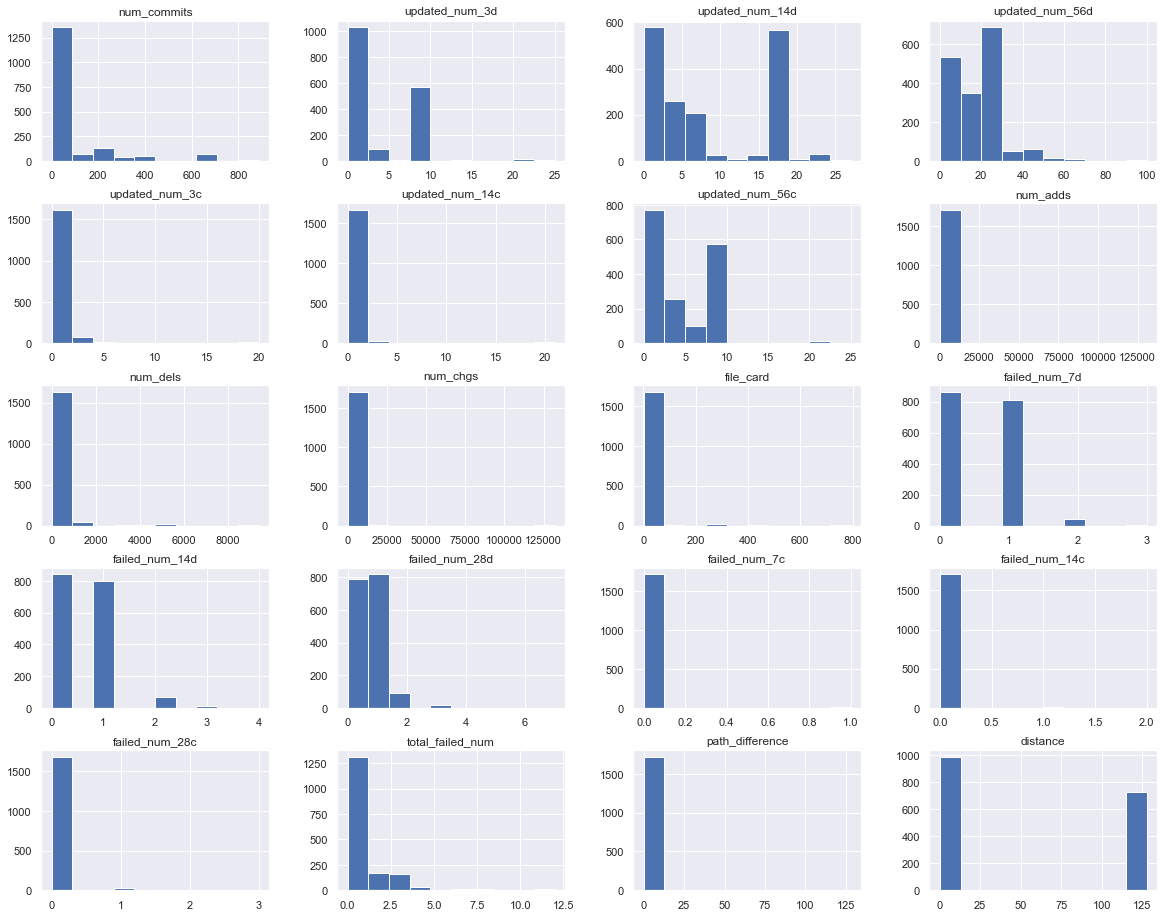

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(20, 16))
X.hist(ax=fig.gca())

In [40]:
# import seaborn as sns
# sns.pairplot(pdf, hue='failed', height=6.0)

import altair as alt
alt.Chart(pdf).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='failed:N'
).properties(width=100, height=100).repeat(row=pdf.columns.tolist(), column=pdf.columns.tolist())

alt.RepeatChart(...)

In [41]:
from sklearn import preprocessing

mm = preprocessing.MinMaxScaler()
norm_data = mm.fit_transform(X)

norm_X = pd.DataFrame(norm_data, columns=X.columns)
norm_pdf = norm_X.copy(deep=True)
norm_pdf['failed'] = y

<AxesSubplot:>

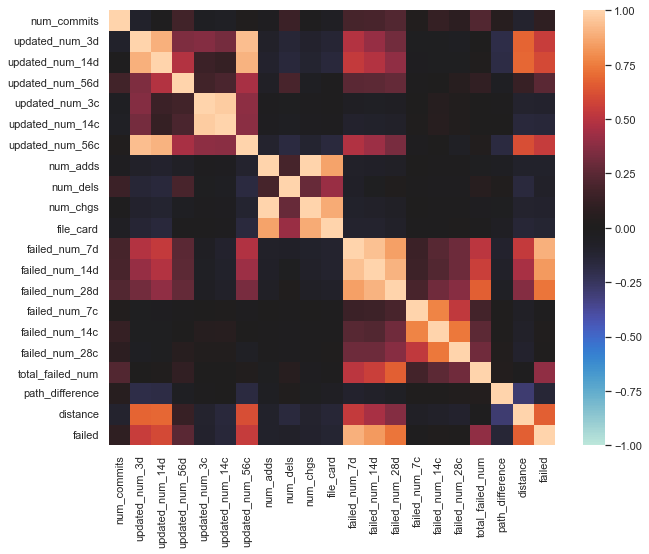

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 8))
sns.heatmap(norm_pdf.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

In [43]:
from minepy import MINE

results = []

mine = MINE(alpha=0.6, c=15, est="mic_approx")

import itertools
for c1, c2 in itertools.combinations(X.columns, 2):
    mine.compute_score(X[c1], X[c2])
    results.append(((c1, c2), mine.mic()))

print(sorted(results, key=lambda x: x[1], reverse=True)[0:3])

[(('num_adds', 'num_chgs'), 0.9823713559213696), (('num_dels', 'num_chgs'), 0.9402866104294406), (('updated_num_14d', 'updated_num_56d'), 0.9276369608333918)]


In [44]:
from minepy import MINE

results = []

mine = MINE(alpha=0.6, c=15, est="mic_approx")

for c in X.columns:
    mine.compute_score(y, X[c])
    results.append((('failed', c), mine.mic()))

print(sorted(results, key=lambda x: x[1], reverse=True)[0:3])

columns_correlated = list(map(lambda x: x[0][1], sorted(results, key=lambda x: x[1], reverse=True)))
columns_correlated

[(('failed', 'failed_num_7d'), 0.8047632653241918), (('failed', 'failed_num_14d'), 0.7599036426235355), (('failed', 'num_chgs'), 0.6862570053742186)]


['failed_num_7d',
 'failed_num_14d',
 'num_chgs',
 'num_dels',
 'failed_num_28d',
 'num_adds',
 'updated_num_56d',
 'updated_num_56c',
 'updated_num_14d',
 'num_commits',
 'updated_num_3d',
 'distance',
 'file_card',
 'total_failed_num',
 'path_difference',
 'updated_num_3c',
 'updated_num_14c',
 'failed_num_28c',
 'failed_num_14c',
 'failed_num_7c']

In [45]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

rf = RandomForestClassifier(n_jobs=-1, max_depth=5)
rf.fit(X, y)
print('SCORE with ALL Features: %1.2f' % rf.score(X, y))

rf = RandomForestClassifier(n_jobs=-1, max_depth=5)
fs = BorutaPy(rf, n_estimators='auto', random_state=0, perc=80, two_step=False, max_iter=500)
fs.fit(X.values, y.values)

selected = fs.support_
print('Selected Features: %s' % ','.join(X.columns[selected]))

X_selected = X[X.columns[selected]]
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)
rf.fit(X_selected, y)
print('SCORE with selected Features: %1.2f' % rf.score(X_selected, y))

SCORE with ALL Features: 0.99
Selected Features: num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,file_card,failed_num_7d,failed_num_14d,failed_num_28d,failed_num_7c,failed_num_14c,failed_num_28c,total_failed_num,path_difference,distance
SCORE with selected Features: 0.99


In [46]:
# columns_selected = X.columns[selected]
columns_selected = columns_correlated[0:6]

<AxesSubplot:xlabel='PCA-X', ylabel='PCA-Y'>

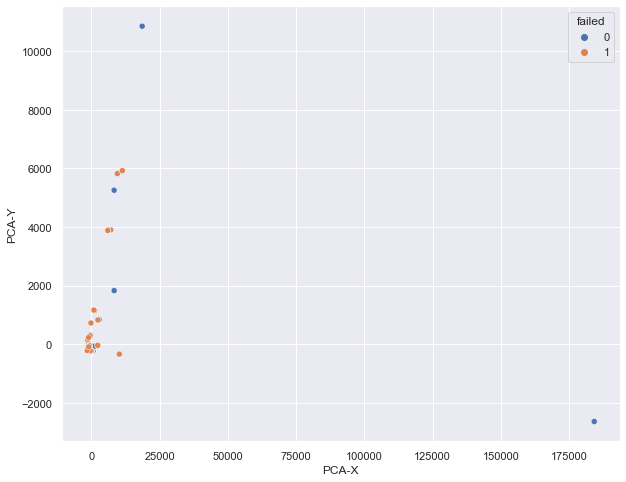

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
_X = pca.fit_transform(X[columns_selected])
_X = pd.DataFrame({'PCA-X': _X[:, 0], 'PCA-Y': _X[:, 1], 'failed': y})

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(data=_X, x='PCA-X', y='PCA-Y', hue='failed', ax=fig.gca())

KL divergence: 0.03688081353902817


<AxesSubplot:xlabel='tSNE-X', ylabel='tSNE-Y'>

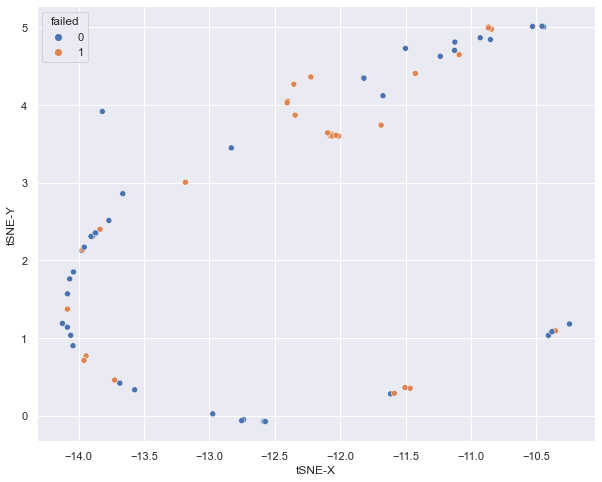

In [48]:
# One of non-linear embedding in sklearn
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
sampled_pdf = pdf.sample(n=100, random_state=0)
tf = tsne.fit_transform(sampled_pdf[columns_selected])
_X = pd.DataFrame({'tSNE-X': tf[:, 0], 'tSNE-Y': tf[:, 1], 'failed': sampled_pdf['failed']})
print('KL divergence: {}'.format(tsne.kl_divergence_))

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(data=_X, x='tSNE-X', y='tSNE-Y', hue='failed', ax=fig.gca())

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[columns_selected], y, stratify=y, test_size=0.33, shuffle=True, random_state=42)

from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '300'}
clf, score = train.build_model(X_train, y_train, opts=params)
print(f'Score: {score}')

import json
top_k = 3
probs = clf.predict_proba(X_test)
pmf = map(lambda p: {"classes": clf.classes_.tolist(), "probs": p.tolist()}, probs)
pmf = map(lambda p: json.dumps(p), pmf)
df = spark.createDataFrame(pd.DataFrame({'y_true': y_test, 'pmf': list(pmf)}))
df = df.selectExpr('y_true', 'from_json(pmf, "classes array<string>, probs array<double>") pmf')
df = df.selectExpr('y_true', 'arrays_zip(pmf.classes, pmf.probs) pmf')
df = df.selectExpr('y_true', 'array_sort(pmf, (left, right) -> if(left.`1` < right.`1`, 1, -1)) pmf')
df = df.selectExpr('y_true', 'pmf[0].`0` y_predicted', 'pmf[0].`1` prob')
df = df.selectExpr('y_true', 'y_predicted', 'prob', 'y_true = y_predicted is_correct')
predicted = df.toPandas()

In [ ]:
predicted[~predicted['is_correct']]

In [ ]:
print('Accuracy: {}'.format(len(predicted[predicted['is_correct']]) / len(predicted)))